# Analysing Music Market Using SQL 

## Introduction 

In this project, I'll be working with Chinook database in order to answer some business questions in the music market using SQL. Chinook is a sample database and the Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers, like a small iTunes Store. 

Here are some facts about Chinook data model:
- Media related data was created using real data from an iTunes Library. 
- Customer and employee information was manually created using fictitious names, addresses that can be located on Google maps, and other well formatted data (phone, fax, email, etc.).
- Sales information is auto generated using random data for a four year period.

The whole information is contained in eleven table. Here is a diagram for the database, which will help us to understand the structure of the data: 


<img src="chinook.jpg">


Let's start with importing the necessary libraries and modules.



In [64]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

***burayi atlayabilirim
### Creating helper functions 

I will begin analysing the data, but before I would like to create some helper functions in python to save time in repeated actions. 


***burayi atlayabilirim

db = 'chinook.db'

# Create a function that takes a SQL query as an argument and returns a pandas dataframe of that query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Create a function that takes a SQL command as an argument and executes it using the sqlite module
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# Create a function that calls the run_query() function to return a list of all tables and views in the database
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view');
    '''
    return run_query(q)

show_tables()

In [6]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [7]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## EXPLORING DATA  
## Analysing the most sold Genres in USA 

Acording to my imaginary scenario for this project, the record store made a deal with a record label and my responsibilty is to select 3 albums from a list of 4, to be added to the store. All of these are brand new artists to us, means that they don't have their tracks on our data base yet. Here are the artist names and the genre of music they make:

|Artist Name     | Genre |
|----------------|-------|
|Regal	         |Hip-Hop|
|Red Tone	     | Punk  |
|Meteor and the Girls|Pop|
|Slim Jim Bites  | Blues |

For this project we are going to focus in the USA market, and find out which genres has the best potential to make profit, so that we can choose the three artists accordingly. 

In order to complete this task, we are going to start by analysing which genres sell the best in the USA. 

I'll wrote a query to discover the best sold genres in the USA, and create a visualization using pandas. 


In [22]:
%%sql

WITH usa_tracks AS
(
SELECT invoice_line.*
FROM invoice_line
JOIN invoice on invoice.invoice_id = invoice_line.invoice_id
WHERE invoice.billing_country = "USA" )

SELECT 
    genre.name AS genre,
    COUNT(usa_tracks.invoice_id) AS tracks_sold,
    cast(COUNT(usa_tracks.invoice_id) AS float) / (SELECT COUNT(usa_tracks.invoice_id) FROM usa_tracks) * 100 AS percentage
FROM
    usa_tracks
INNER JOIN track on track.track_id = usa_tracks.track_id
INNER JOIN genre on genre.genre_id = track.genre_id
GROUP BY 1
ORDER BY 2 DESC


 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage
Rock,561,53.37773549000951
Alternative & Punk,130,12.369172216936251
Metal,124,11.798287345385347
R&B/Soul,53,5.042816365366318
Blues,36,3.425309229305423
Alternative,35,3.3301617507136063
Pop,22,2.093244529019981
Latin,22,2.093244529019981
Hip Hop/Rap,20,1.9029495718363463
Jazz,14,1.3320647002854424


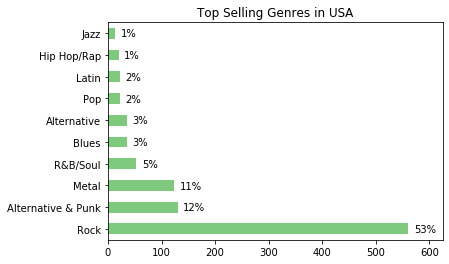

In [28]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
albums_to_purchase = '''
WITH usa_tracks_sold AS
     (
      SELECT il.*
      FROM invoice_line il
      INNER JOIN invoice i ON i.invoice_id = il.invoice_id
      INNER JOIN customer c on c.customer_id = i.customer_id
      WHERE c.country = 'USA'
     )
      
SELECT 
      g.name genre_name,
      COUNT(uts.invoice_line_id) number_of_tracks_sold,
      CAST(COUNT(uts.invoice_line_id) AS FLOAT)/(
           SELECT COUNT(*) FROM usa_tracks_sold
      ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON t.track_id = uts.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
    
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('genre_name', drop = True, inplace = True)

genre_sales_usa['number_of_tracks_sold'].plot.barh(
     title = 'Top Selling Genres in USA',
     xlim = (0, 625),
     colormap = plt.cm.Accent
    )
plt.ylabel('')

for i,label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label,'number_of_tracks_sold']
    label = (genre_sales_usa.loc[label, 'percentage_sold'] * 100).astype(int).astype(str) + '%'
    plt.annotate(str(label),(score + 10, i - 0.15))

plt.show()


Based on these results, we can easily see that the most sold genre in the USA is ROCK with over 50% followed by Alternative & Punk by 12% and Metal 11%. 

In this case we are going to choose the artist who makes the most popular music in the USA, which are Punk, Blues and Pop music. The music genre that we are going to exclude is Hip Hop because it has only a 1% share in the whole US music market. 

The artist we choose after analysing our date are:
- Red Tone (Punk) 12%
- Slim Jim Bites (Blues) 3% 
- Meteor and the Girls (Pop) 2%

Even though we have chosen these artists, we can see that these are not very strong genres in the USA music market. Focusing on rock music would be a smarter idea, if our main concern is the sales. We can suggest to concentrate findi ng and adding some new rock artists in our store.


## Analysing Employee Sales Performances

As a next step I am going analyse the performance of the sales support agents. According to the data base some agents perferoming better than others and my aim is to figure out its reasons. As the main criteria of employee performance, I am going to use the total dollar sales amount and I am going to use the whole invoice table this time instead of using only USA. 

Firstly let's get familiar with the data and understand what kind of information we have in the database:

In [42]:
employee_table = '''
SELECT * FROM employee;
'''
run_query(employee_table)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
5,6,Mitchell,Michael,IT Manager,1.0,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
6,7,King,Robert,IT Staff,6.0,1970-05-29 00:00:00,2017-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
7,8,Callahan,Laura,IT Staff,6.0,1968-01-09 00:00:00,2017-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


We can see that there are only 3 Sales Support Agent. 

I will need to write a query that finds the total dollar amount of sales assigned to each sales support agent within the company to understand the picture better. 

In [47]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT 
          c.customer_id,
          c.support_rep_id, 
          SUM(i.total) total
     FROM customer c 
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT 
     e.first_name || " " || e.last_name employee_name,
     e.hire_date,
     SUM(csrs.total) total_sales,
     e.birthdate
FROM employee e
INNER JOIN customer_support_rep_sales csrs ON csrs.support_rep_id = e.employee_id
WHERE e.title = 'Sales Support Agent'
GROUP BY 1
ORDER BY 3 DESC;
'''

run_query(employee_sales_performance)

,employee_name,hire_date,total_sales,birthdate
0,Jane Peacock,2017-04-01 00:00:00,1731.51,1973-08-29 00:00:00
1,Margaret Park,2017-05-03 00:00:00,1584.00,1947-09-19 00:00:00
2,Steve Johnson,2017-10-17 00:00:00,1393.92,1965-03-03 00:00:00


In [45]:
'''%%sql

SELECT 
employee.first_name || " " || employee.last_name AS employee_name,
SUM(invoice.total) as total_sales,
employee.hire_date,
employee.birthdate,
FROM employee 
INNER JOIN customer on customer.support_rep_id = employee.employee_id
INNER JOIN invoice on invoice.customer_id = customer.customer_id
GROUP BY 1
ORDER BY 2 DESC'''


'%%sql\n\nSELECT \nemployee.first_name || " " || employee.last_name AS employee_name,\nSUM(invoice.total) as total_sales,\nemployee.hire_date,\nemployee.birthdate,\nFROM employee \nINNER JOIN customer on customer.support_rep_id = employee.employee_id\nINNER JOIN invoice on invoice.customer_id = customer.customer_id\nGROUP BY 1\nORDER BY 2 DESC'

Let's plot these results to make them more readable: 

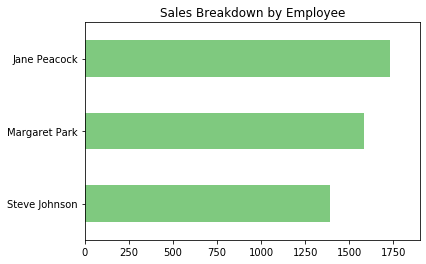

In [37]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index('employee_name', inplace = True, drop = True)

employee_sales.sort_values('total_sales', inplace = True)
employee_sales['total_sales'].plot.barh(
                title = 'Sales Breakdown by Employee',
                legend = False,
                xlim = (0, 1900),
                colormap = plt.cm.Accent
                )
plt.ylabel('')
plt.show()


At first there seem to be a big difference between the employee total sales. But, we need to check out the hire date in order to understand the picture better. 

Jane entered exactly one month before Margaret and Steve started 5 months after Margaret. So we can say that the difference between Margaret and Jane was supposed to be much smaller than the difference between Steve and Margaret (5 times to be exact). At this point we can also guess that the age of the employees plays a role in the sales. But before making any prejudiced decisions, it would be wise to conduct a performance review in order to get a clearer picture about the employee performances. 

## Analysing Sales by Country

My next mission in this project is to collect some information based on the counrty. The questions that I need to answer are:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

In the dataset some countries have just one customer, I will group these countries as "Other".

Let's start with calculating the total number of customers by country:


In [53]:
"""%%sql

SELECT 
    customer.country AS country,
    count(customer.customer_id) AS no_customers,
    CAST(SUM(invoice.total) AS int) AS total_value_sales,
    SUM(invoice.total) /  CAST((count(customer.customer_id)) AS float) AS average
FROM
    customer 
INNER JOIN invoice on invoice.customer_id = customer.customer_id
INNER JOIN invoice_line on invoice_line.invoice_id = invoice.invoice_id
GROUP BY 1
ORDER BY 3 DESC
"""


'%%sql\n\nSELECT \n    customer.country AS country,\n    count(customer.customer_id) AS no_customers,\n    CAST(SUM(invoice.total) AS int) AS total_value_sales,\n    SUM(invoice.total) /  CAST((count(customer.customer_id)) AS float) AS average\nFROM\n    customer \nINNER JOIN invoice on invoice.customer_id = customer.customer_id\nINNER JOIN invoice_line on invoice_line.invoice_id = invoice.invoice_id\nGROUP BY 1\nORDER BY 3 DESC\n'

In [54]:
"""%%sql

SELECT 
    customer.country AS country,
    (SELECT COUNT(customer.customer_id) FROM customer GROUP BY customer.country) AS no_customer,
    CASE 
        WHEN count(customer.customer_id) > 1 THEN 1
        ELSE 0  
    END AS sort,
    cast(SUM(invoice_line.unit_price) AS int) AS total_sales,
    SUM(invoice_line.unit_price) / count(customer.customer_id) AS avg_order
FROM 
    customer
INNER JOIN invoice on invoice.customer_id = customer.customer_id 
INNER JOIN invoice_line on invoice_line.invoice_id = invoice.invoice_id
GROUP BY 1
ORDER BY 4 DESC """

'%%sql\n\nSELECT \n    customer.country AS country,\n    (SELECT COUNT(customer.customer_id) FROM customer GROUP BY customer.country) AS no_customer,\n    CASE \n        WHEN count(customer.customer_id) > 1 THEN 1\n        ELSE 0  \n    END AS sort,\n    cast(SUM(invoice_line.unit_price) AS int) AS total_sales,\n    SUM(invoice_line.unit_price) / count(customer.customer_id) AS avg_order\nFROM \n    customer\nINNER JOIN invoice on invoice.customer_id = customer.customer_id \nINNER JOIN invoice_line on invoice_line.invoice_id = invoice.invoice_id\nGROUP BY 1\nORDER BY 4 DESC '

In [50]:
%%sql

WITH others AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT 
    country,
    count(distinct customer_id) AS no_customers,
    SUM(unit_price) AS total_sales,
    SUM(unit_price) / cast(count(distinct customer_id) AS float) AS avg_or_val,
    SUM(unit_price) / count(distinct invoice_id) average_order
FROM 
others
GROUP BY 1
ORDER BY 2 DESC


 * sqlite:///chinook.db
Done.


country,no_customers,total_sales,avg_or_val,average_order
Other,15,1094.9400000000085,72.99600000000056,7.448571428571486
USA,13,1040.490000000008,80.03769230769292,7.942671755725252
Canada,8,535.5900000000034,66.94875000000043,7.047236842105309
France,5,389.0700000000021,77.81400000000042,7.781400000000042
Brazil,5,427.68000000000245,85.53600000000048,7.011147540983647
Germany,4,334.6200000000016,83.6550000000004,8.161463414634186
United Kingdom,3,245.52000000000078,81.84000000000026,8.768571428571457
Portugal,2,185.13000000000022,92.56500000000011,6.3837931034482835
India,2,183.1500000000002,91.5750000000001,8.72142857142858
Czech Republic,2,273.24000000000103,136.62000000000052,9.108000000000034


I will need to push the "Other" at the end of the table so that I have a more accurate result:

In [55]:
%%sql

WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )
    
SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC


 * sqlite:///chinook.db
Done.


country,customers,total_sales,customer_lifetime_value,average_order,sort
USA,13,1040.490000000008,80.03769230769292,7.942671755725252,0
Canada,8,535.5900000000034,66.94875000000043,7.047236842105309,0
Brazil,5,427.68000000000245,85.53600000000048,7.011147540983647,0
France,5,389.0700000000021,77.81400000000042,7.781400000000042,0
Germany,4,334.6200000000016,83.6550000000004,8.161463414634186,0
Czech Republic,2,273.24000000000103,136.62000000000052,9.108000000000034,0
United Kingdom,3,245.52000000000078,81.84000000000026,8.768571428571457,0
Portugal,2,185.13000000000022,92.56500000000011,6.3837931034482835,0
India,2,183.1500000000002,91.5750000000001,8.72142857142858,0
Other,15,1094.9400000000085,72.99600000000056,7.448571428571486,1


Let's visualise these result, plotting will help to read the information better. 

In [66]:
# analyzing sales by country
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
         CASE
             WHEN
                 (SELECT COUNT(*)
                  FROM customer
                  WHERE country = c.country
                 ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )

SELECT 
    country,
    total_num_customers,
    total_sales_value,
    avg_sales_customer,
    avg_order_value
FROM
    (
     SELECT
         country,
         COUNT(DISTINCT (customer_id)) total_num_customers,
         TOTAL(unit_price) total_sales_value,
         TOTAL(unit_price) / COUNT(DISTINCT (customer_id)) avg_sales_customer,
         TOTAL(unit_price) / COUNT(DISTINCT (invoice_id)) avg_order_value,
         CASE
             WHEN country = "Other" THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort, total_sales_value DESC 
    );
'''


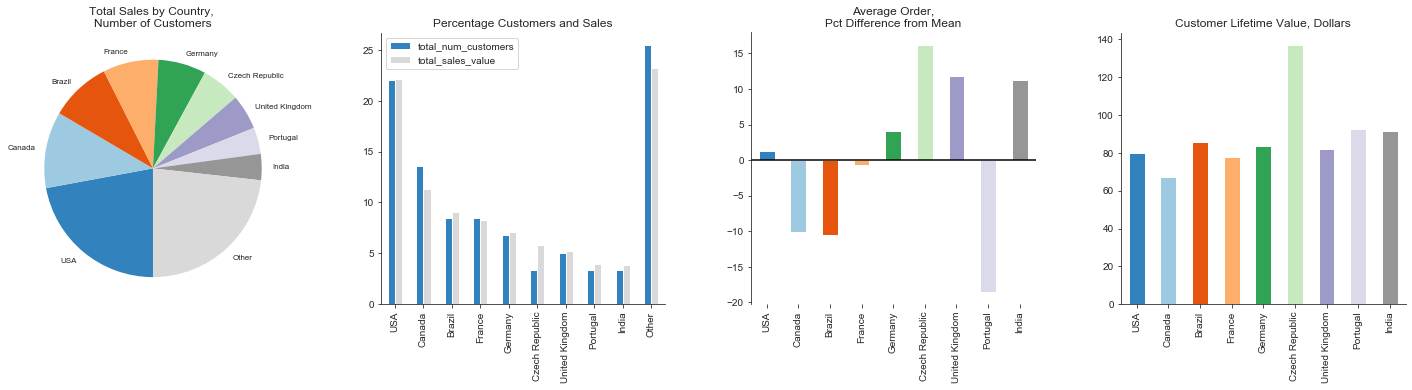

In [80]:
country_sales_df = run_query(sales_by_country)

# set index and dropping column that is selected as index
country_sales_df.set_index('country', inplace=True, drop=True)

# set colormap 
colors = [plt.cm.tab20c(i) for i in np.linspace(0, 1, country_sales_df.shape[0])]

# instantiate a figure object and creating subplots/axes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,5))

# unpack the axes/subplots for customized editing/plotting
ax1, ax2, ax3, ax4 = axes.flatten()

# adjust the height and width of subplots
fig.subplots_adjust(hspace=.5, wspace=.3)

# 1. total sales by country - (1,1)
sales_plot = country_sales_df['total_sales_value'].copy().rename('')
sales_plot.plot.pie(ax=ax1, colormap=plt.cm.tab20c,
                    title='Total Sales by Country, \nNumber of Customers', 
                    startangle=-90, counterclock=False, 
                    fontsize=8, wedgeprops={'linewidth':0}
                   )


# 2. percentage customers and sales - (1,2)
cols = ['total_num_customers', 'total_sales_value']
customers_and_sales = country_sales_df[cols].copy()
customers_and_sales.index.name = ''
for c in cols:
    customers_and_sales[c] /= customers_and_sales[c].sum() / 100
customers_and_sales.plot.bar(ax=ax2, colormap=plt.cm.tab20c,
                            title='Percentage Customers and Sales'
                           )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')


# 3. average order - (2,1)
avg_order = country_sales_df['avg_order_value'].copy()
avg_order.index.name = ''
mean_diff_from_avg = avg_order * 100 / avg_order.mean() - 100
# dropping 'Other' group as it's not required here
mean_diff_from_avg.drop('Other', inplace=True)
mean_diff_from_avg.plot.bar(ax=ax3, color=colors,
                            title='Average Order,\nPct Difference from Mean'
                           )
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.axhline(0, color='k')
# Hide the right,top and bottom spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
# Only show ticks on the left and bottom spines
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')


# 4. customer liftime value - (2,2)
avg_customer_sales = country_sales_df['avg_sales_customer'].copy()
avg_customer_sales.index.name = ''
# dropping 'Other' group as it's not required here
avg_customer_sales.drop('Other',inplace=True)
avg_customer_sales.plot.bar(ax=ax4, color=colors, 
                            title='Customer Lifetime Value, Dollars'
                           )
ax4.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')

plt.show()

In [56]:
"""%%sql 

SELECT invoice_line.* FROM invoice_line INNER JOIN track on track.track_id = invoice_line.track_id"""

'%%sql \n\nSELECT invoice_line.* FROM invoice_line INNER JOIN track on track.track_id = invoice_line.track_id'